Libraries

In [527]:
#pip install geopandas

In [528]:
#pip install plotly

In [593]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import geopandas as gpd
import plotly.express as px
from shapely import wkt
import shapely

Style

In [530]:
pd.options.mode.chained_assignment = None

In [531]:
plt.rcParams.update({'font.family':'Arial'})

In [532]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

In [533]:
%matplotlib inline

In [534]:
plt.rcParams['figure.figsize'] = (20,10)

In [535]:
saved_style_state = matplotlib.rcParams.copy()

In [536]:
pd.set_option('display.max_rows', None)

Reading files...

In [537]:
ev = pd.read_csv("IEA-EV-data.csv")

In [538]:
world_geo = pd.read_csv("world_geo.csv")

In [539]:
country = pd.read_csv("countries.csv")

In [540]:
energy = pd.read_csv("energy.csv")

In [541]:
renewable_share = pd.read_csv("renewable-share-energy.csv")

In [542]:
share_elec = pd.read_csv("share-electricity-renewables.csv")

In [543]:
loc = pd.read_csv("locations.csv")


In [544]:
burbs = gpd.GeoDataFrame.from_file('NOV21_NSW_LOC_POLYGON_shp')
burbs.set_crs(epsg=5234, inplace=True, allow_override=True) 
burbs.sample(2)

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
68,lcp5233ed7f1944,loc2d4f47816b45,2021-06-24,Arable,Gazetted Locality,NSW,"POLYGON ((148.98935 -36.32426, 148.98744 -36.3..."
1018,lcp598be3fb1cb4,locc8fc49528aa2,2021-09-08,Comboyne,Gazetted Locality,NSW,"POLYGON ((152.47987 -31.53192, 152.47927 -31.5..."


In [545]:
cols_to_drop = ["NSW_LOCA_1", "NSW_LOCA_3", "NSW_LOCA_4","NSW_LOCA_5","NSW_LOCA_7", "DT_RETIRE"]
burbs.drop(cols_to_drop, axis=1, inplace=True, errors="ignore")
burbs.head(2)

,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
0,lcp012ec80364d0,loc56c2712d9100,2021-06-24,Aarons Pass,Gazetted Locality,NSW,"POLYGON ((149.79499 -32.82275, 149.79403 -32.8..."
1,lcp4c73aef97a2a,loc826143633965,2021-09-08,Abbotsbury,Gazetted Locality,NSW,"POLYGON ((150.87268 -33.86044, 150.87254 -33.8..."


locations

In [596]:
df_geo = gpd.GeoDataFrame(loc, geometry = gpd.points_from_xy(loc.Longitude, loc.Latitude))

In [547]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

w = world.continent == 'Oceania'

world = world[w]

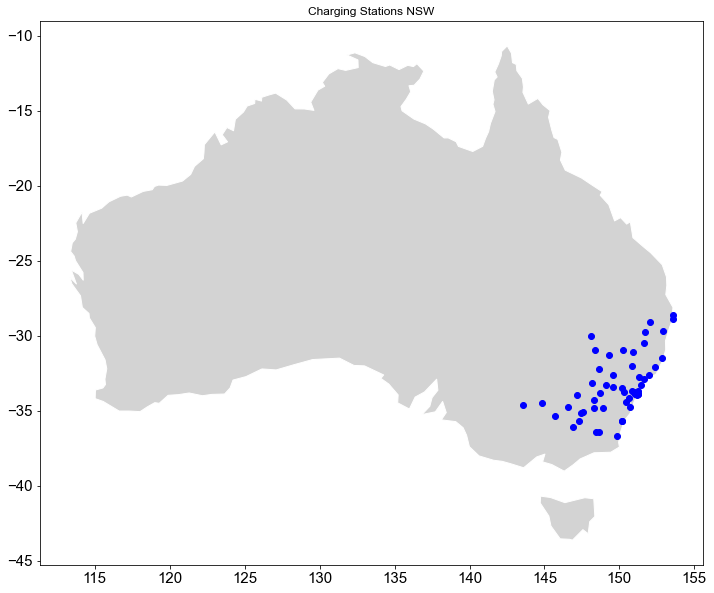

In [548]:

ax = world[world.name == 'Australia'].plot(color='lightgrey', edgecolor='white')
df_geo.plot(ax=ax, color='blue')

plt.title('Charging Stations NSW')

plt.show()

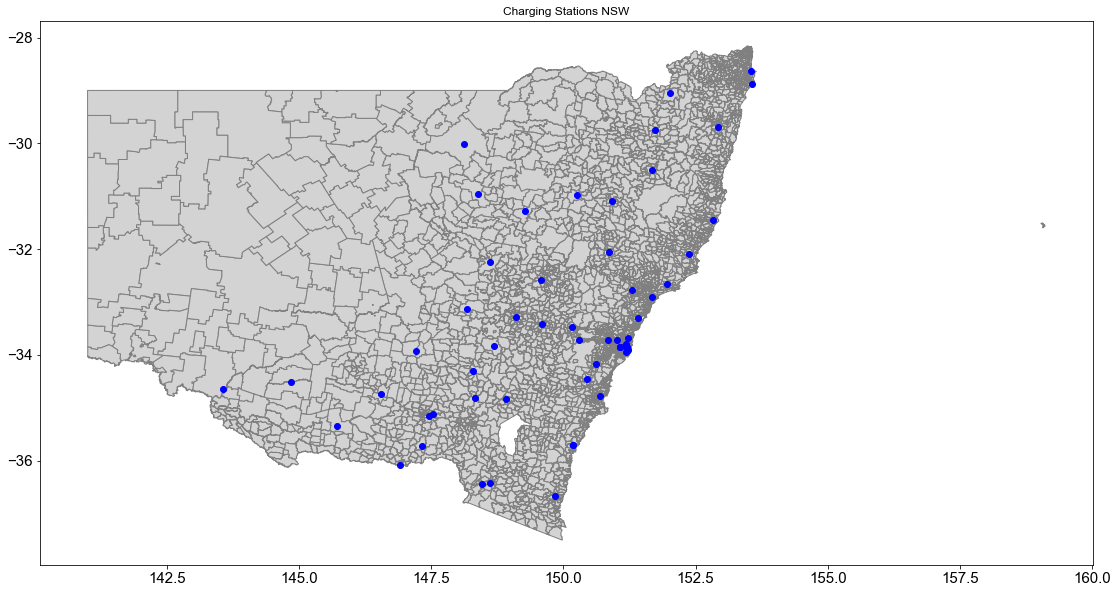

In [592]:
ax = burbs.plot(color='lightgrey', edgecolor = 'grey')

df_geo.plot(ax=ax, color='blue')

plt.title('Charging Stations NSW')

plt.show()

# Choropleth (Share of Total Sales from Electric Cars) 2011-2021

In [550]:
# Sales share data for chosen country

def sales_share(country):
    v = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    return v

In [551]:
# Filtered DataFrame

e = ev.category == 'Historical'
evs = ev[e]
s = evs.parameter == 'EV sales share'
ev_s = evs[s]
t = ev_s['mode'] == 'Cars'
ev_share = ev_s[t]

te = ev_share.year != 2010

ev_fin = ev_share[te]

ev_fin.rename(columns = {'value': 'percentage %'}, inplace = True)

ev_fin.columns

Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'percentage %'],
      dtype='object')

In [552]:
# Visualisation

map1 = px.choropleth(ev_fin,
locations = 'region',
locationmode = 'country names',
color = 'percentage %',
animation_frame = 'year',
scope = 'world',
height = 750,
range_color = (0,65),
title = 'Share of Total Sales from Electric Cars',
color_continuous_scale = 'plotly3',

)

map1

# Bar plot (Share of Total Sales from Electric Cars) Comparing 2018 to 2021

In [553]:
ev_simple = ev_fin.drop(['category', 'mode', 'parameter', 'unit', 'powertrain'], axis=1)

In [554]:
# Gets 2021 sales share data of chosen country

def sales_share_latest(country):
    s = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    last = s.iloc[-1].value

    return last

In [555]:
# Gets 2018 sales share data of chosen country

def sales_share_earliest(country):
    s = ev[(ev.region == country) & (ev.parameter == 'EV sales share') & (ev.category == 'Historical') & (ev['mode'] == 'Cars')]

    first = s.iloc[-4].value

    return first

In [556]:
# Creating Recorded Countries List

country_list = []

for c in ev.region:
    if c not in country_list:
        country_list.append(c)

country_list.remove('World')
country_list.remove('Europe')
country_list.remove('Rest of the world')
country_list.remove('Other Europe')
country_list.remove('Indonesia')
country_list.remove('Thailand')

country_list[15] = 'South Korea'

country_list = sorted(country_list)

country_list[-1] = country_list[-2]
country_list[-2] = 'United Kingdom'


In [557]:
# Creating lists with Sales Data

shares_latest = []
for c in country_list:
    if c == 'South Korea':
        shares_latest.append(f"{sales_share_latest('Korea')}")
    else:
        shares_latest.append(f"{sales_share_latest(c)}")

shares_earliest = []
for c in country_list:
    if c == 'South Korea':
        shares_earliest.append(f"{sales_share_earliest('Korea')}")
    else:
        shares_earliest.append(f"{sales_share_earliest(c)}")

shares_latest = list(map(float, shares_latest))
shares_earliest = list(map(float, shares_earliest))


l = len(shares_latest)
l2 = len(shares_earliest)


In [558]:
# Creating new DataFrame

df = pd.DataFrame({'2021': shares_latest})
df1 = pd.DataFrame({'2018': shares_earliest})
df2 = pd.DataFrame({'country': country_list})

all_shares = pd.concat([df2, df1, df], axis=1)
all_shares = all_shares.sort_values('2021')


In [603]:
eight = all_shares['2018']

twenty = all_shares['2021']

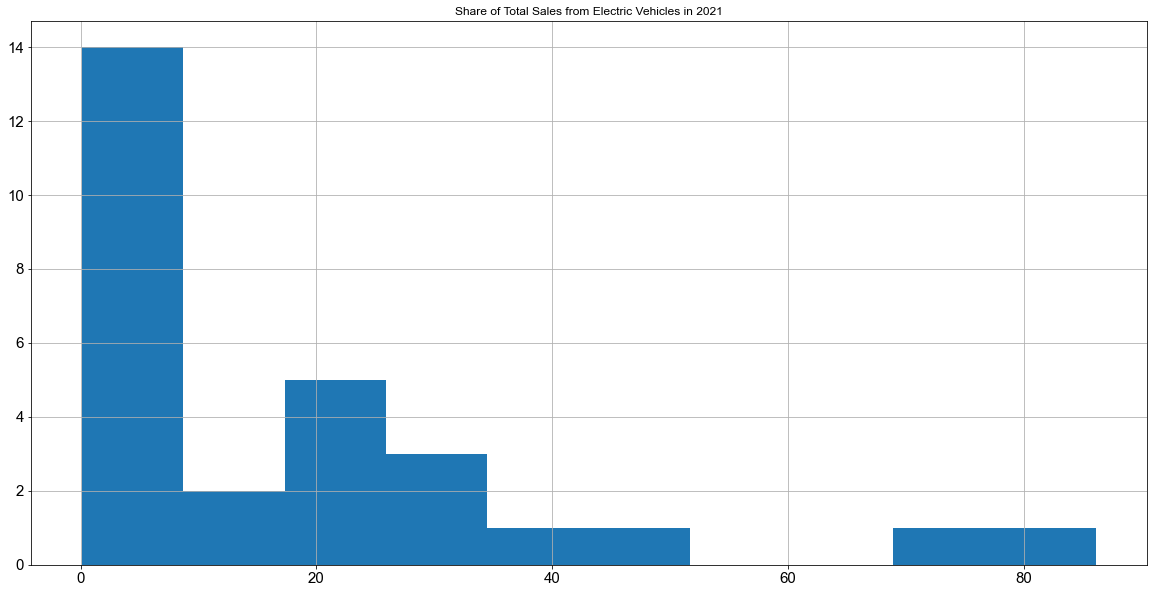

In [609]:

twenty.hist()
plt.title('Share of Total Sales from Electric Vehicles in 2021')
plt.show()



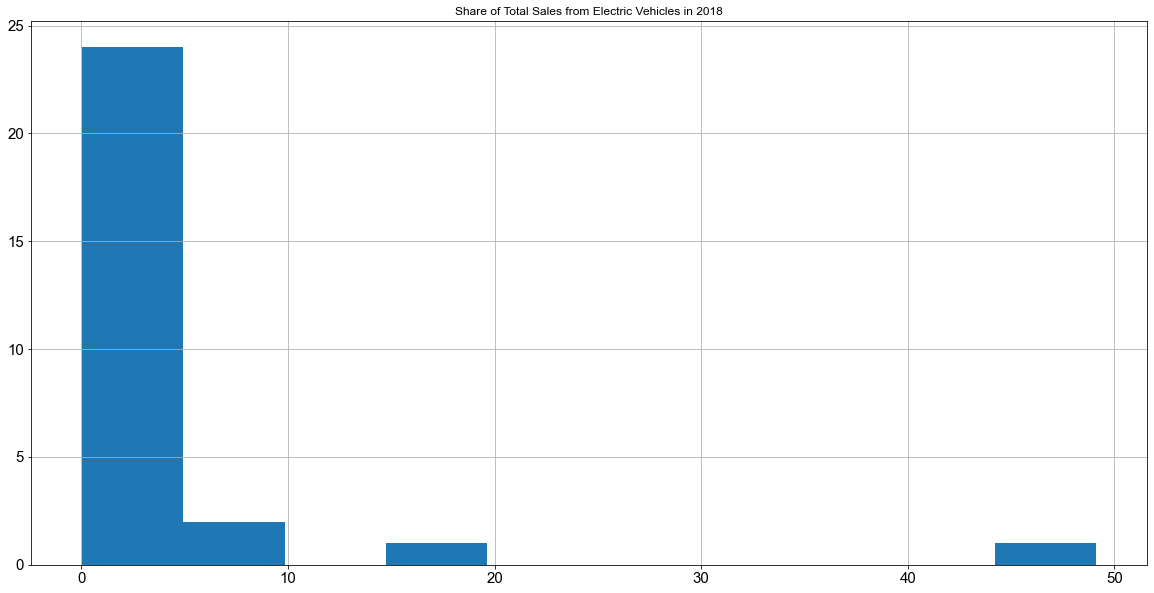

In [610]:
eight.hist()
plt.title('Share of Total Sales from Electric Vehicles in 2018')
plt.show()

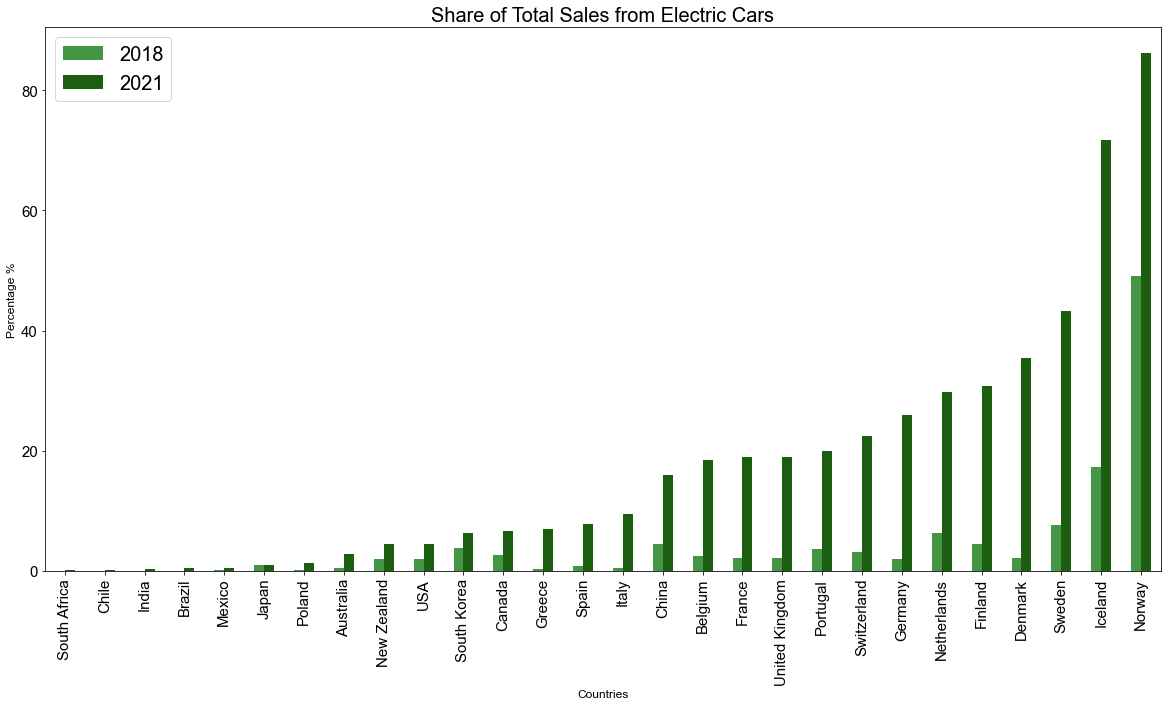

In [559]:
# Visualisation

all_shares.plot(kind = 'bar', 
x = 'country', 
stacked = False,
xlabel = 'Countries',
fontsize = '12',
color = {'2018': '#449644','2021': '#1b5e0f'}
)
plt.title('Share of Total Sales from Electric Cars', fontsize=20)

plt.xlabel('Countries', fontsize=12)
plt.ylabel('Percentage %', fontsize=12)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(prop={'size': 20})

plt.show()

# Bar Plot (Share of Primary Energy from Renewable Sources) Comparing 2000 with 2021

In [560]:
# Gets 2021 data for chosen country

is_21 = renewable_share.Year == 2021
share_21 = renewable_share[is_21]
share_21 = share_21.reset_index()
share_21 = share_21.drop('index', axis=1)

def get_2021(c):
    for i in range(len(share_21.Entity)):
        if share_21.Entity[i] == c:
            a = share_21['Renewables (% equivalent primary energy)'][i]

    #r = pd.DataFrame([a], columns=[c]) not required

    return a


In [561]:
# Gets 2000 data for chosen country

is_00 = renewable_share.Year == 2000
share_00 = renewable_share[is_00]
share_00 = share_00.reset_index()
share_00 = share_00.drop('index', axis=1)

def get_2000(c):
    for i in range(len(share_00.Entity)):
        if share_00.Entity[i] == c:
            a = share_00['Renewables (% equivalent primary energy)'][i]

    #r = pd.DataFrame([a], columns=[c]) not required

    return a

In [562]:
# Getting countries 2000

k = get_2000('Iceland')
w = get_2000('World')
e = get_2000('Europe')
af = get_2000('Africa')
a = get_2000('Asia')
ap = get_2000('Asia Pacific (BP)')
t = get_2000('Trinidad and Tobago')
au = get_2000('Australia')
o = get_2000('Oceania')

to_2000 = [af, a, ap, au, w, e, o]
countries = ['Africa', 'Asia', 'Asia Pacific (BP)', 'Australia', 'World', 'Europe', 'Oceania']

In [563]:
sorted_21 = share_21.sort_values(by=['Renewables (% equivalent primary energy)'])

In [564]:
# Getting countries 2021

ksi = get_2021('Iceland')
wor = get_2021('World')
eur = get_2021('Europe')
afr = get_2021('Africa')
asi = get_2021('Asia')
asp = get_2021('Asia Pacific (BP)')
tnt = get_2021('Trinidad and Tobago')
aus = get_2021('Australia')
oce = get_2021('Oceania')

to_2021 = [afr, asi, asp, aus, wor, eur, oce]
countries = ['Africa', 'Asia', 'Asia Pacific (BP)', 'Australia', 'World', 'Europe', 'Oceania']


In [565]:
lowest = 0
entity = []
for i in share_21.Entity:
    r = get_2021(i)
    if lowest < r < 25:
        lowest = r
        entity.append(i)

print(f"{lowest}, {entity[-1]}")


highest = 0
ent = []
for j in share_21.Entity:
     k = get_2021(j)
     if k > highest:
        highest = k
        ent.append(j)

print(f"{highest}, {ent[-1]}")

23.91737174987793, Latvia
86.8745346069336, Iceland


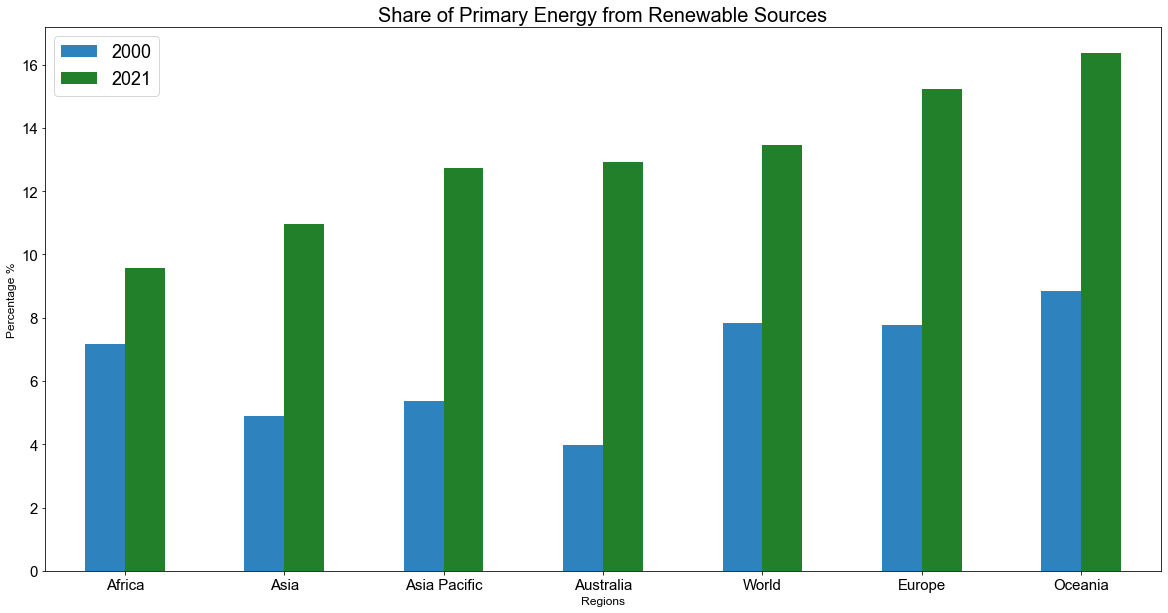

In [566]:
# Visualisation

index = ['Africa', 'Asia', 'Asia Pacific', 'Australia', 'World', 'Europe', 'Oceania']

comp_00_21 = pd.DataFrame({'2000': to_2000, '2021': to_2021}, index=index)

ax = comp_00_21.plot.bar(rot=0, color={'2000': '#2e83bf', '2021': '#218029'})

plt.title('Share of Primary Energy from Renewable Sources', fontsize=20)

plt.legend(prop={'size':18})

plt.xlabel('Regions', fontsize=12)
plt.ylabel('Percentage %', fontsize=12)

plt.show()

# Line Graph (Share of Primary Energy from Renewable Sources) 1965-2021

In [567]:
# Gets DataFrame with data for chosen country

def is_country(country):
    r = renewable_share.Entity == country
    ren = renewable_share[r]
    lst = list(ren['Renewables (% equivalent primary energy)'])
    df = pd.DataFrame(lst, columns=[country])
    return df

In [568]:
# Countries 

period = list(range(1965,2022))
aus = is_country('Australia')
nor = is_country('Norway')
usa = is_country('United States')
nzl = is_country('New Zealand')
fin = is_country('Finland')
can = is_country('Canada')
swe = is_country('Sweden')
chi = is_country('China')
ice = is_country('Iceland')
zaf = is_country('South Africa')
unk = is_country('United Kingdom')
wor = is_country('World')
eur = is_country('Europe')
ger = is_country('Germany')

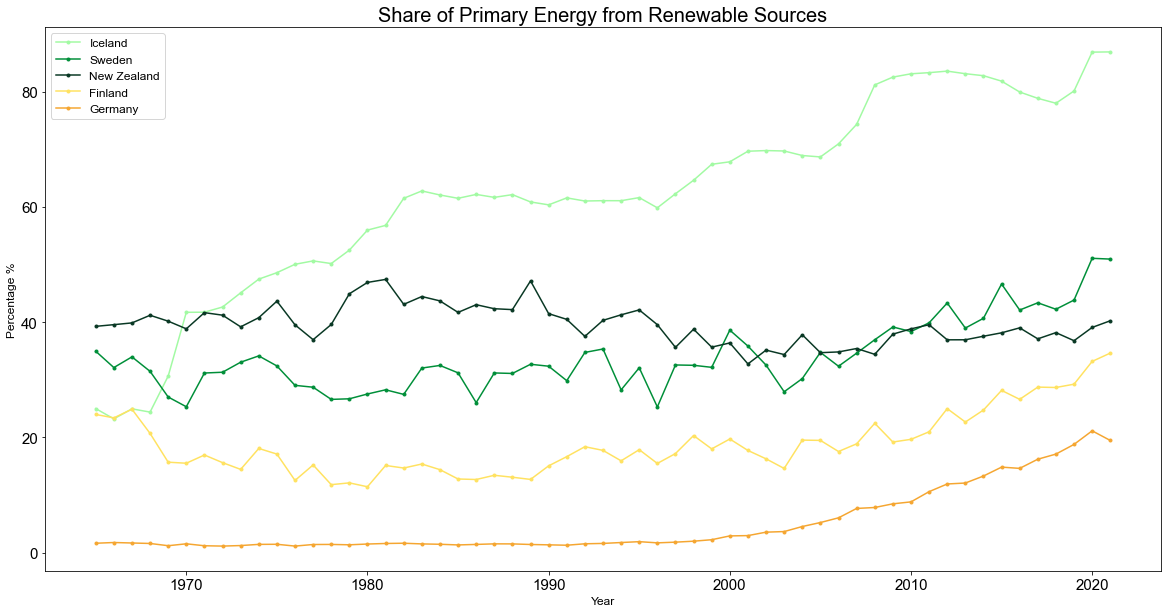

In [569]:
# Visualisation

renewable = pd.DataFrame(period, columns=['Year'])
com_ren = pd.concat([renewable, aus, nor, usa, nzl, fin, can, swe, chi, ice, zaf, unk, wor, eur, ger], axis=1)

plt.title('Share of Primary Energy from Renewable Sources', fontsize=20)
plt.plot(com_ren.Year, com_ren.Iceland, '.-', color='#A2FAA3', label='Iceland')
plt.plot(com_ren.Year, com_ren.Sweden, '.-', color='#008F39', label='Sweden')
plt.plot(com_ren.Year, com_ren['New Zealand'], '.-', color='#093824', label='New Zealand')
plt.plot(com_ren.Year, com_ren.Finland, '.-', color='#ffe261', label='Finland')
plt.plot(com_ren.Year, com_ren.Germany, '.-', color='#f5a631', label='Germany')

plt.xlabel('Year', fontsize=12)

plt.ylabel('Percentage %', fontsize=12)

plt.legend(loc='upper left', prop={'size':12})

plt.show()

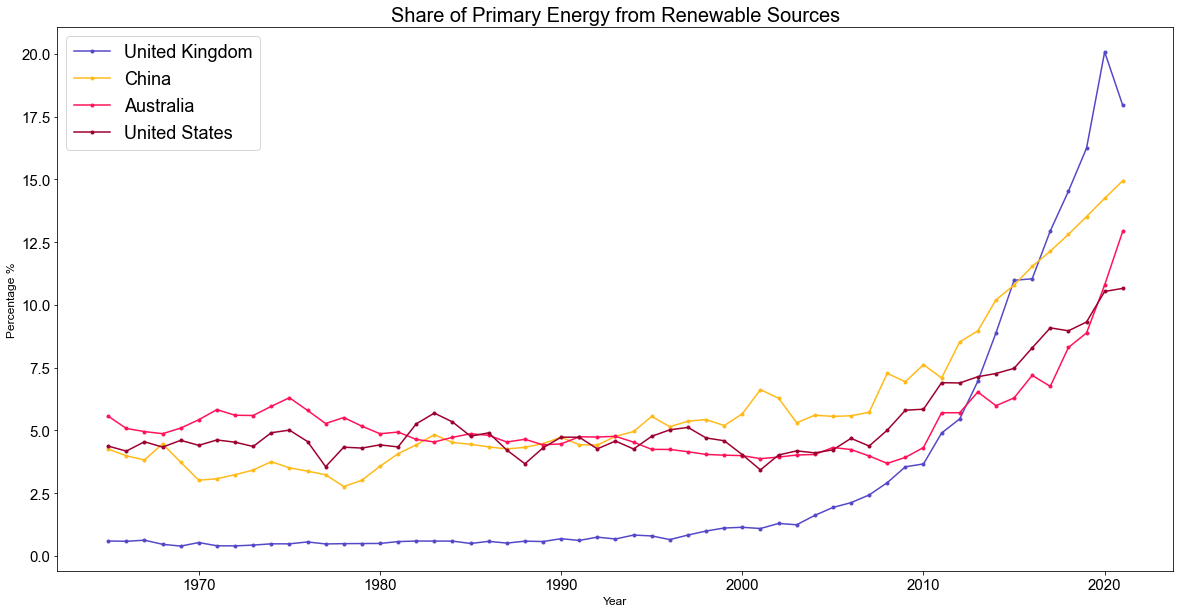

In [570]:
# Visualisation

renewable = pd.DataFrame(period, columns=['Year'])
com_ren = pd.concat([renewable, aus, nor, usa, nzl, fin, can, swe, chi, ice, zaf, unk], axis=1)

plt.title('Share of Primary Energy from Renewable Sources', fontsize=20)
plt.plot(com_ren.Year, com_ren['United Kingdom'], '.-', color='#5448C8', label='United Kingdom')
plt.plot(com_ren.Year,com_ren.China, '.-', color='#ffba19', label='China')
plt.plot(com_ren.Year, com_ren.Australia, '.-', color='#ff1259', label='Australia')
plt.plot(com_ren.Year, com_ren['United States'], '.-', color='#9c002f', label='United States')

plt.xlabel('Year', fontsize=12)

plt.ylabel('Percentage %', fontsize=12)

plt.legend(loc='upper left', prop={'size':18})

plt.show()

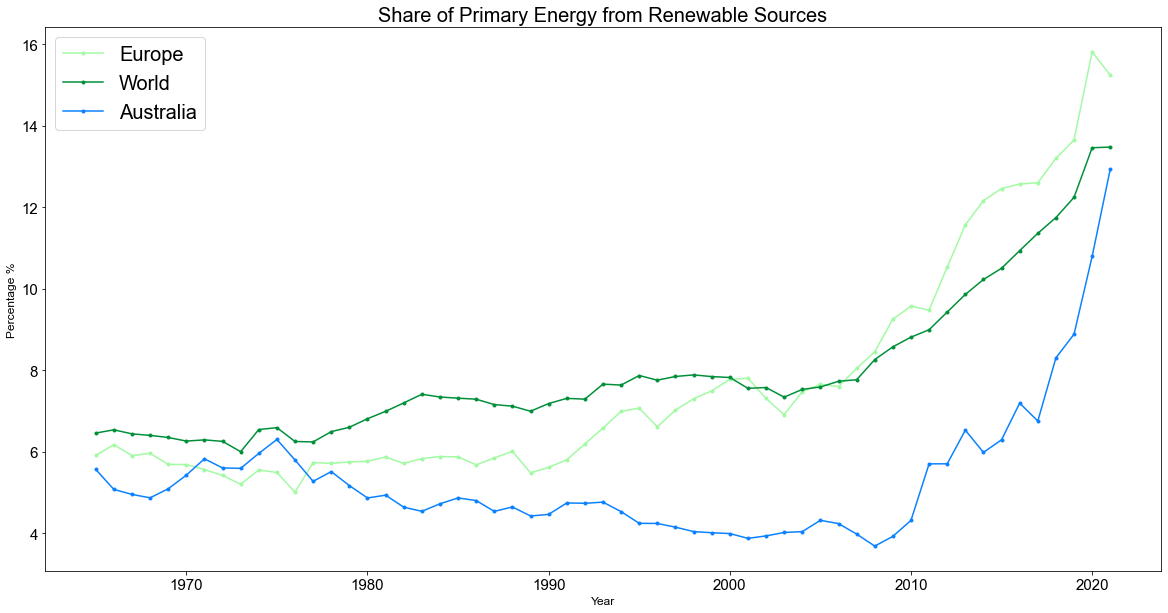

In [571]:
# Visualisation

renewable = pd.DataFrame(period, columns=['Year'])
com_ren = pd.concat([renewable, aus, nor, usa, nzl, fin, can, swe, chi, ice, zaf, unk, wor, eur], axis=1)

plt.title('Share of Primary Energy from Renewable Sources', fontsize=20)
plt.plot(com_ren.Year, com_ren.Europe, '.-', color='#A2FAA3', label='Europe')
plt.plot(com_ren.Year, com_ren.World, '.-', color='#008F39', label='World')
plt.plot(com_ren.Year, com_ren.Australia, '.-', color='#0a81ff', label='Australia')



plt.xlabel('Year', fontsize=12)

plt.ylabel('Percentage %', fontsize=12)

plt.legend(loc='upper left', prop={'size':20})

plt.show()

# Choropleth (Share of Primary Energy from Renewable Sources) 1965-2021

In [572]:
# Filtered DataFrame

cull = renewable_share['Entity'].isin(world_geo.name)
a_share = renewable_share[cull]
us = renewable_share['Entity'] == 'United States'
us_ren = renewable_share[us]
eq = pd.concat([a_share, us_ren], axis=0)


In [573]:
# Visualisation

px.choropleth(eq,
locations = 'Entity',
locationmode = 'country names',
color = 'Renewables (% equivalent primary energy)',
animation_frame = 'Year',
scope = 'world',
height = 750,
range_color = (0,75),
title = 'Share of Primary Energy from Renewable Sources (1965 to 2021)',
color_continuous_scale = 'Plasma',

)

# Line Graph Share of EV Sales vs. Share of Renewables (Australia)

In [574]:
def get_sales_share(country):
    a = sales_share(country)
    a2 = a.year >= 2011
    a3 = a[a2]
    b = a3.drop(['parameter', 'region', 'category', 'mode', 'powertrain', 'unit', 'year'], axis=1)
    c = b.rename(columns = {'value': f'{country}1'})

    ab = c.reset_index()

    abc = ab.drop('index', axis=1)

    return abc

In [575]:
shares_aus = get_sales_share('Australia')
shares_nz = get_sales_share('New Zealand')
shares_us = get_sales_share('USA')
shares_uk = get_sales_share('United Kingdom')
shares_w = get_sales_share('World')
shares_eu = get_sales_share('Europe')
shares_oe = get_sales_share('Other Europe')

In [576]:

def is_country_comp(country):
    r = renewable_share.Entity == country
    ren = renewable_share[r]
    c = ren.Year >= 2011
    ren = ren[c]
    lst = list(ren['Renewables (% equivalent primary energy)'])
    df = pd.DataFrame(lst, columns=[country])
    return df

In [577]:
yer = list(range(2011, 2022))
renew_aus = is_country_comp('Australia')
renew_nz = is_country_comp('New Zealand')
ys = pd.DataFrame(yer)

In [578]:
ys.rename(columns = {0: 'year'}, inplace=True)
total = pd.concat([ys, shares_aus, shares_w, shares_eu, shares_oe], axis=1)

In [579]:
aus_ren = is_country_comp('Australia')

In [580]:
world_ren = is_country_comp('World')

list_r = list(world_ren.World)
list_we = list(shares_w.World1)

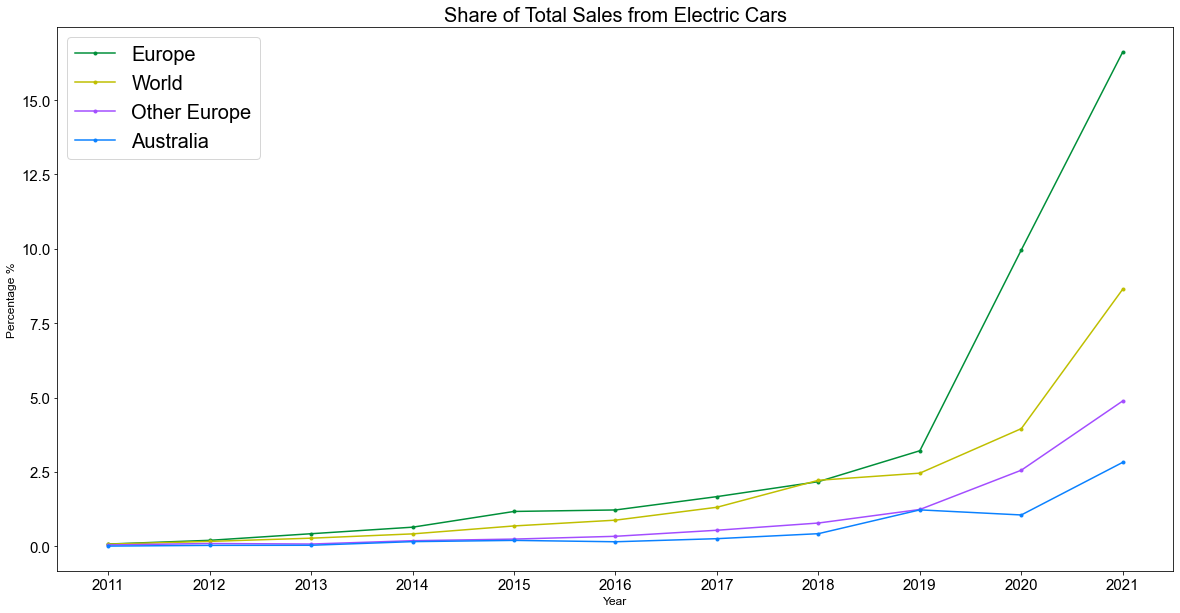

In [581]:
ys = list(range(2011, 2022))

plt.title('Share of Total Sales from Electric Cars', fontsize=20)
plt.plot(total.year, total.Europe1, '.-', color='#008F39', label='Europe')
plt.plot(total.year, total.World1, '.-', color='y', label='World')
plt.plot(total.year, total['Other Europe1'], '.-', color='#a34dff', label='Other Europe')
plt.plot(total.year, total.Australia1, '.-', color='#0a81ff', label='Australia')



plt.xticks(ys)
plt.xlabel('Year', fontsize=12)

plt.ylabel('Percentage %', fontsize=12)

plt.legend(loc='upper left', prop={'size':20})

plt.show()

In [582]:
y = list(range(2011,2022))

years = pd.DataFrame(y)

total_aus = pd.concat([shares_aus, aus_ren], axis=1)

list_rs = list(total_aus.Australia)

list_ev = list(total_aus.Australia1)

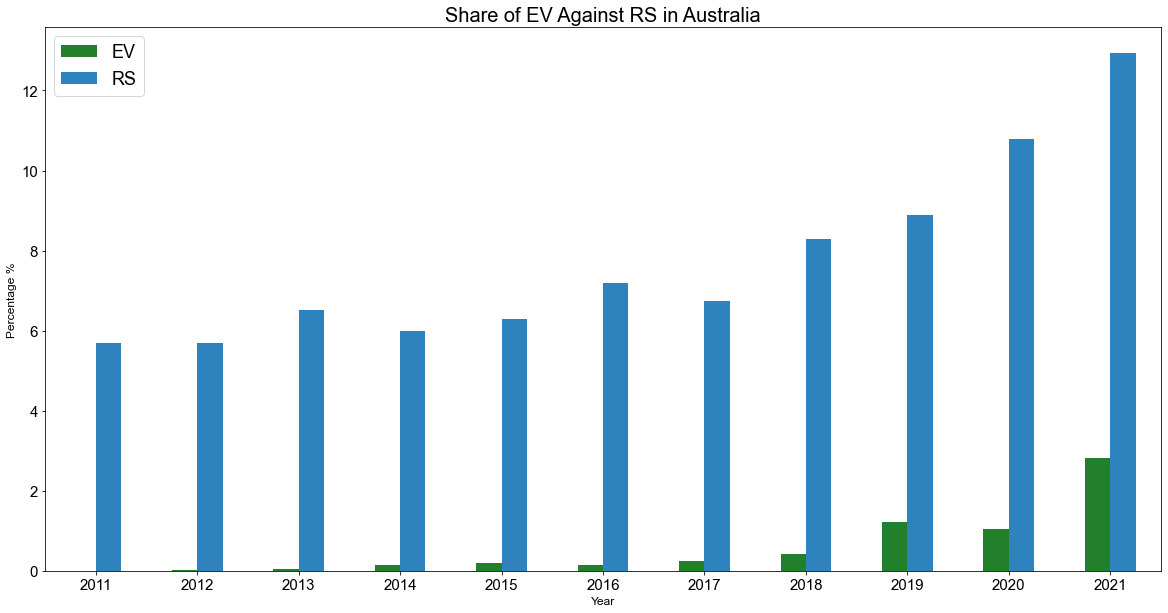

In [583]:


total_aus = pd.DataFrame({'EV': list_ev, 'RS': list_rs}, index=y)

ax = total_aus.plot.bar(rot=0, color={'EV': '#218029', 'RS': '#2e83bf'})

plt.title('Share of EV Against RS in Australia', fontsize=20)

plt.legend(prop={'size':18})

plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage %', fontsize=12)

plt.show()

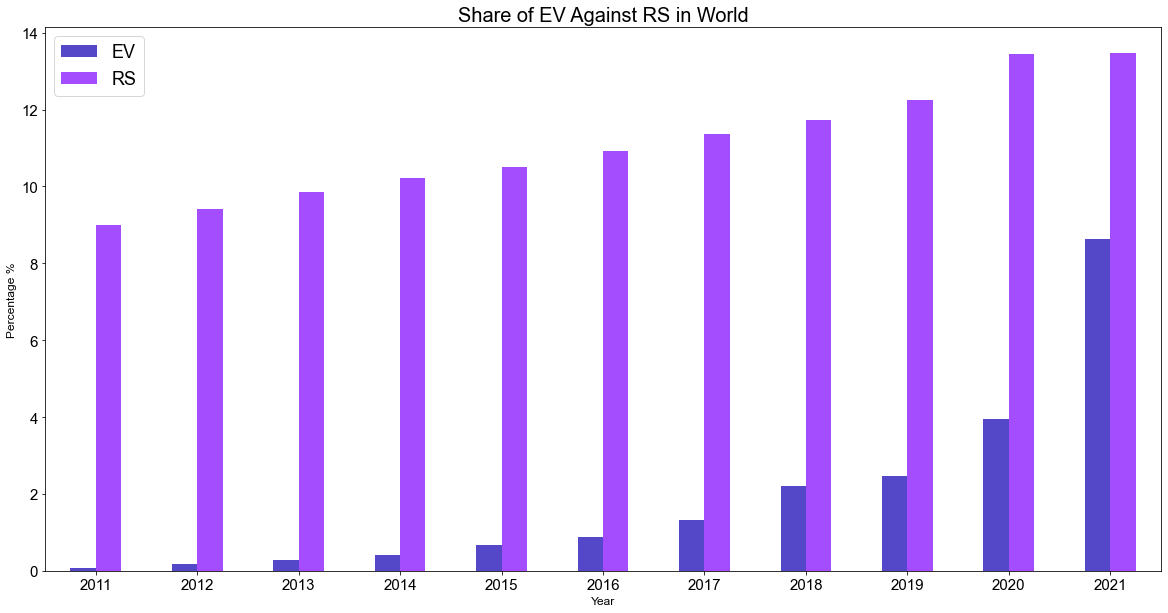

In [584]:
total_world = pd.DataFrame({'EV': list_we, 'RS': list_r}, index=y)

ax = total_world.plot.bar(rot=0, color={'EV': '#5448C8', 'RS': '#a34dff'})

plt.title('Share of EV Against RS in World', fontsize=20)

plt.legend(prop={'size':18})

plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage %', fontsize=12)

plt.show()

In [585]:
shares_eu
shares_euren = is_country_comp('Europe')

list_eu = list(shares_euren.Europe)
list_eev = list(shares_eu.Europe1)

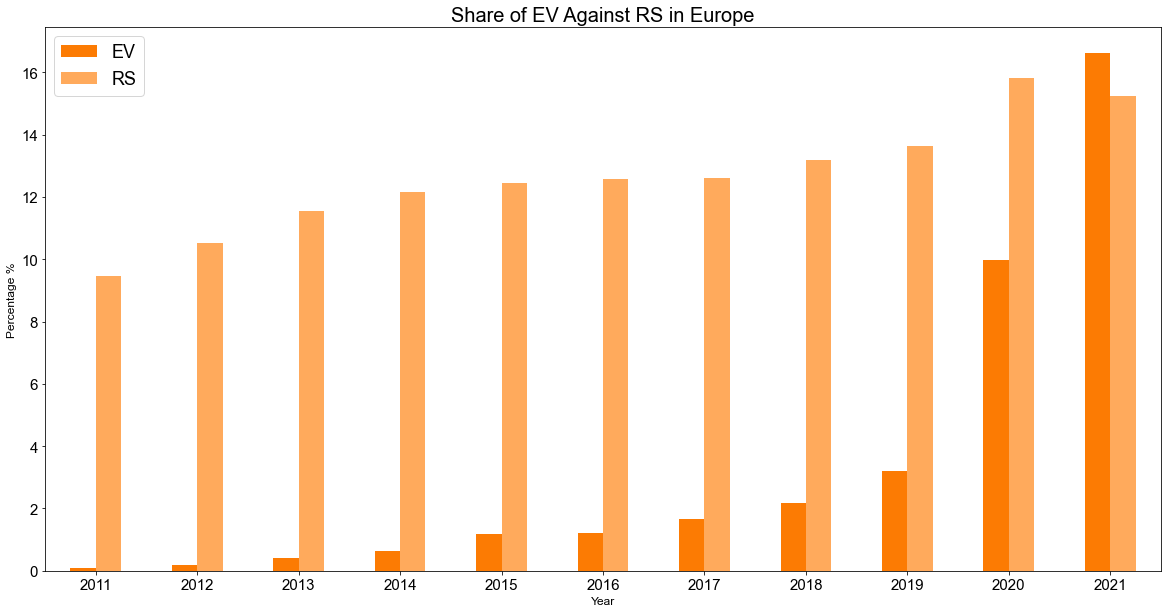

In [586]:
total_europe = pd.DataFrame({'EV': list_eev, 'RS': list_eu}, index=y)

ax = total_europe.plot.bar(rot=0, color={'EV': '#fc7b03', 'RS': '#ffaa5c'})

plt.title('Share of EV Against RS in Europe', fontsize=20)

plt.legend(prop={'size':18})

plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage %', fontsize=12)

plt.show()

In [587]:

def is_country_elec(country):
    r = share_elec.Entity == country
    ren = share_elec[r]
    c = ren.Year >= 2011
    ren = ren[c]
    lst = list(ren['Renewables (% electricity)'])
    df = pd.DataFrame(lst, columns=[f'{country}E'])
    return df

In [588]:
aus_elec = is_country_elec('Australia')

list_aus_elec = list(aus_elec.AustraliaE)

world_elec = is_country_elec('World')

list_world_elec = list(world_elec.WorldE)

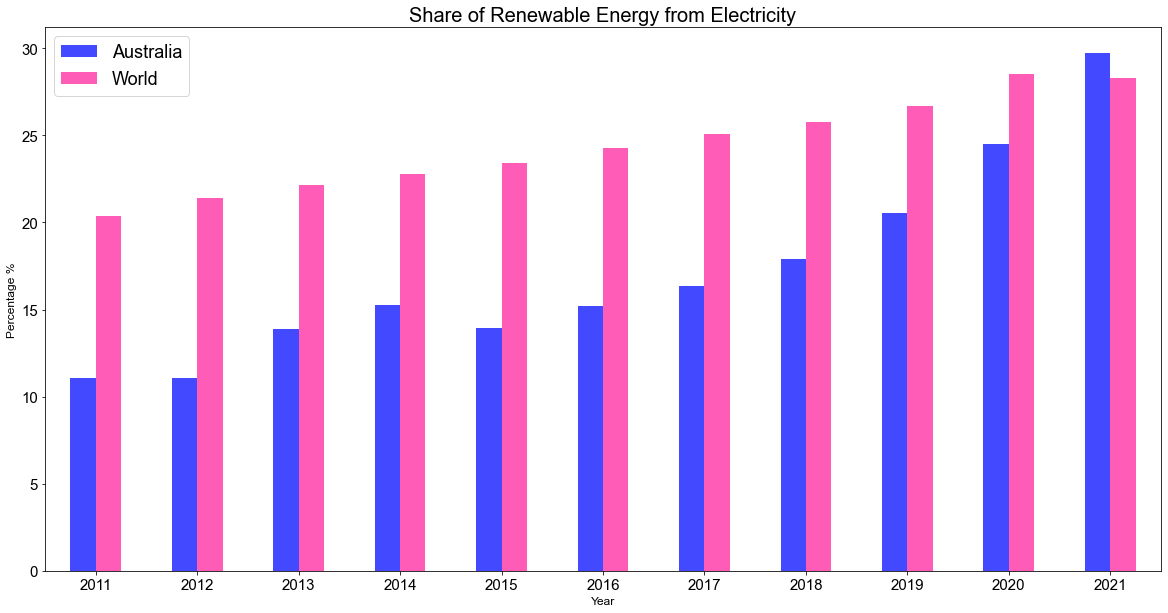

In [589]:
total_elec = pd.DataFrame({'Australia': list_aus_elec, 'World': list_world_elec}, index=y)

ax = total_elec.plot.bar(rot=0, color={'Australia': '#4249ff', 'World': '#ff5cb8'})

plt.title('Share of Renewable Energy from Electricity', fontsize=20)

plt.legend(prop={'size':18})

plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage %', fontsize=12)

plt.show()